In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install pytorch-pretrained-bert pytorch-nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification, BertConfig
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import os
import gc
# % matplotlib inline

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

## Load Dataset


In [ ]:
df = pd.read_csv("data.tsv", sep='\t')
df.shape

(6421, 3)

In [ ]:
df.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [ ]:
df["label"]

0       real
1       real
2       fake
3       real
4       real
        ... 
6416    fake
6417    fake
6418    fake
6419    real
6420    real
Name: label, Length: 6421, dtype: object

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(df["tweet"], df["label"], random_state=2018, test_size=0.1)
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(5778,)
(643,)
(5778,)
(643,)


In [ ]:
del df
gc.collect()

120

In [ ]:
# Create sentence and label lists
# sentences = df["question"].values
sentences = train_X.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
# labels = df['main_category'].values
labels = train_y.values

In [ ]:
# sentences

In [ ]:
label_list = train_y.unique()
print(len(label_list))
print(label_list)

2
['real' 'fake']


In [ ]:
del train_X
del train_y
gc.collect()

88

## Inputs

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:03<00:00, 70619.10B/s]


Tokenize the first sentence:
['[CLS]', 'there', 'are', 'nine', 'people', 'with', 'co', '##vid', '-', '19', 'in', 'hospitals', '-', 'two', 'in', 'auckland', 'city', 'hospital', 'four', 'people', 'in', 'middle', '##more', 'two', 'people', 'in', 'north', 'shore', 'hospital', 'and', 'one', 'person', 'in', 'wai', '##kato', 'hospital', '.', 'six', 'people', 'are', 'stable', 'on', 'a', 'ward', 'and', 'three', 'people', 'in', 'middle', '##more', 'are', 'in', 'ic', '##u', '.', '[SEP]']


In [ ]:
del sentences
gc.collect()

22

In [ ]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

In [ ]:
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts], maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
del tokenized_texts
gc.collect()

22

In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.111)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.111)

In [ ]:
del input_ids
del labels
del attention_masks
gc.collect()

44

In [ ]:
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_labels = train_labels.astype('str')
validation_labels = validation_labels.astype('str')

train_labels = encoder.fit_transform(train_labels)
validation_labels = encoder.fit_transform(validation_labels)

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


## Train Model

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
# config = BertConfig.from_pretrained('bert-base-uncased')
# config.num_labels = len(label_list)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_list))
# model = BertForSequenceClassification(config)
model.cuda()

100%|██████████| 407873900/407873900 [00:33<00:00, 12215147.51B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

For the purposes of fine-tuning, we are following hyperparameter ranges:
- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Store our loss and accuracy for plotting
train_loss_set = []
valid_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 2

# creating the tokenizer directory to save the model
if not os.path.exists('tokenizer/'):
    os.mkdir('tokenizer/')

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  
  train_loss_set.append(tr_loss/nb_tr_steps)
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))


# model.save_pretrained('tokenizer/')

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1174.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.21900850288014603


Epoch:  50%|█████     | 1/2 [02:11<02:11, 131.24s/it]

Validation Accuracy: 0.96875
Train loss: 0.04760338239348638


Epoch: 100%|██████████| 2/2 [04:26<00:00, 133.01s/it]

Validation Accuracy: 0.96875


In [ ]:
output_model_file = "./tokenizer/model_file.bin"
output_config_file = "./tokenizer/config_file.bin"
output_vocab_file = "./tokenizer/"

model_to_save = model.module if hasattr(model, 'module') else model
torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_vocabulary(output_vocab_file)

'./tokenizer/vocab.txt'

## Training Evaluation

Let's take a look at our training loss over all batches:

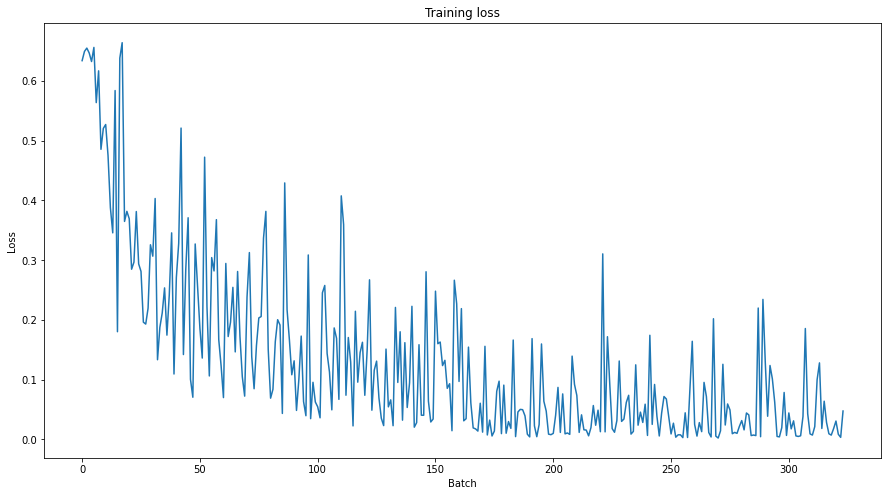

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score